In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import time
from ctypes import cdll
from scipy.integrate import quad
from scipy.special import gamma, spence
from scipy.optimize import minimize_scalar
from numba import jit
import scipy.odr as odr
from Burkert_profile_functions import *
from NFW_profile_functions import *
from Sersic_profile_functions import *
import os
import shutil
import math
from gaussian_functions import *
from DM_halo_functions import *
from GC_functions import *
from modified_GC_functions import *
from Re_functions import *
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Simulation points

<Axes3DSubplot:xlabel='log Halo Mass M*', ylabel='log GC Mass M*'>

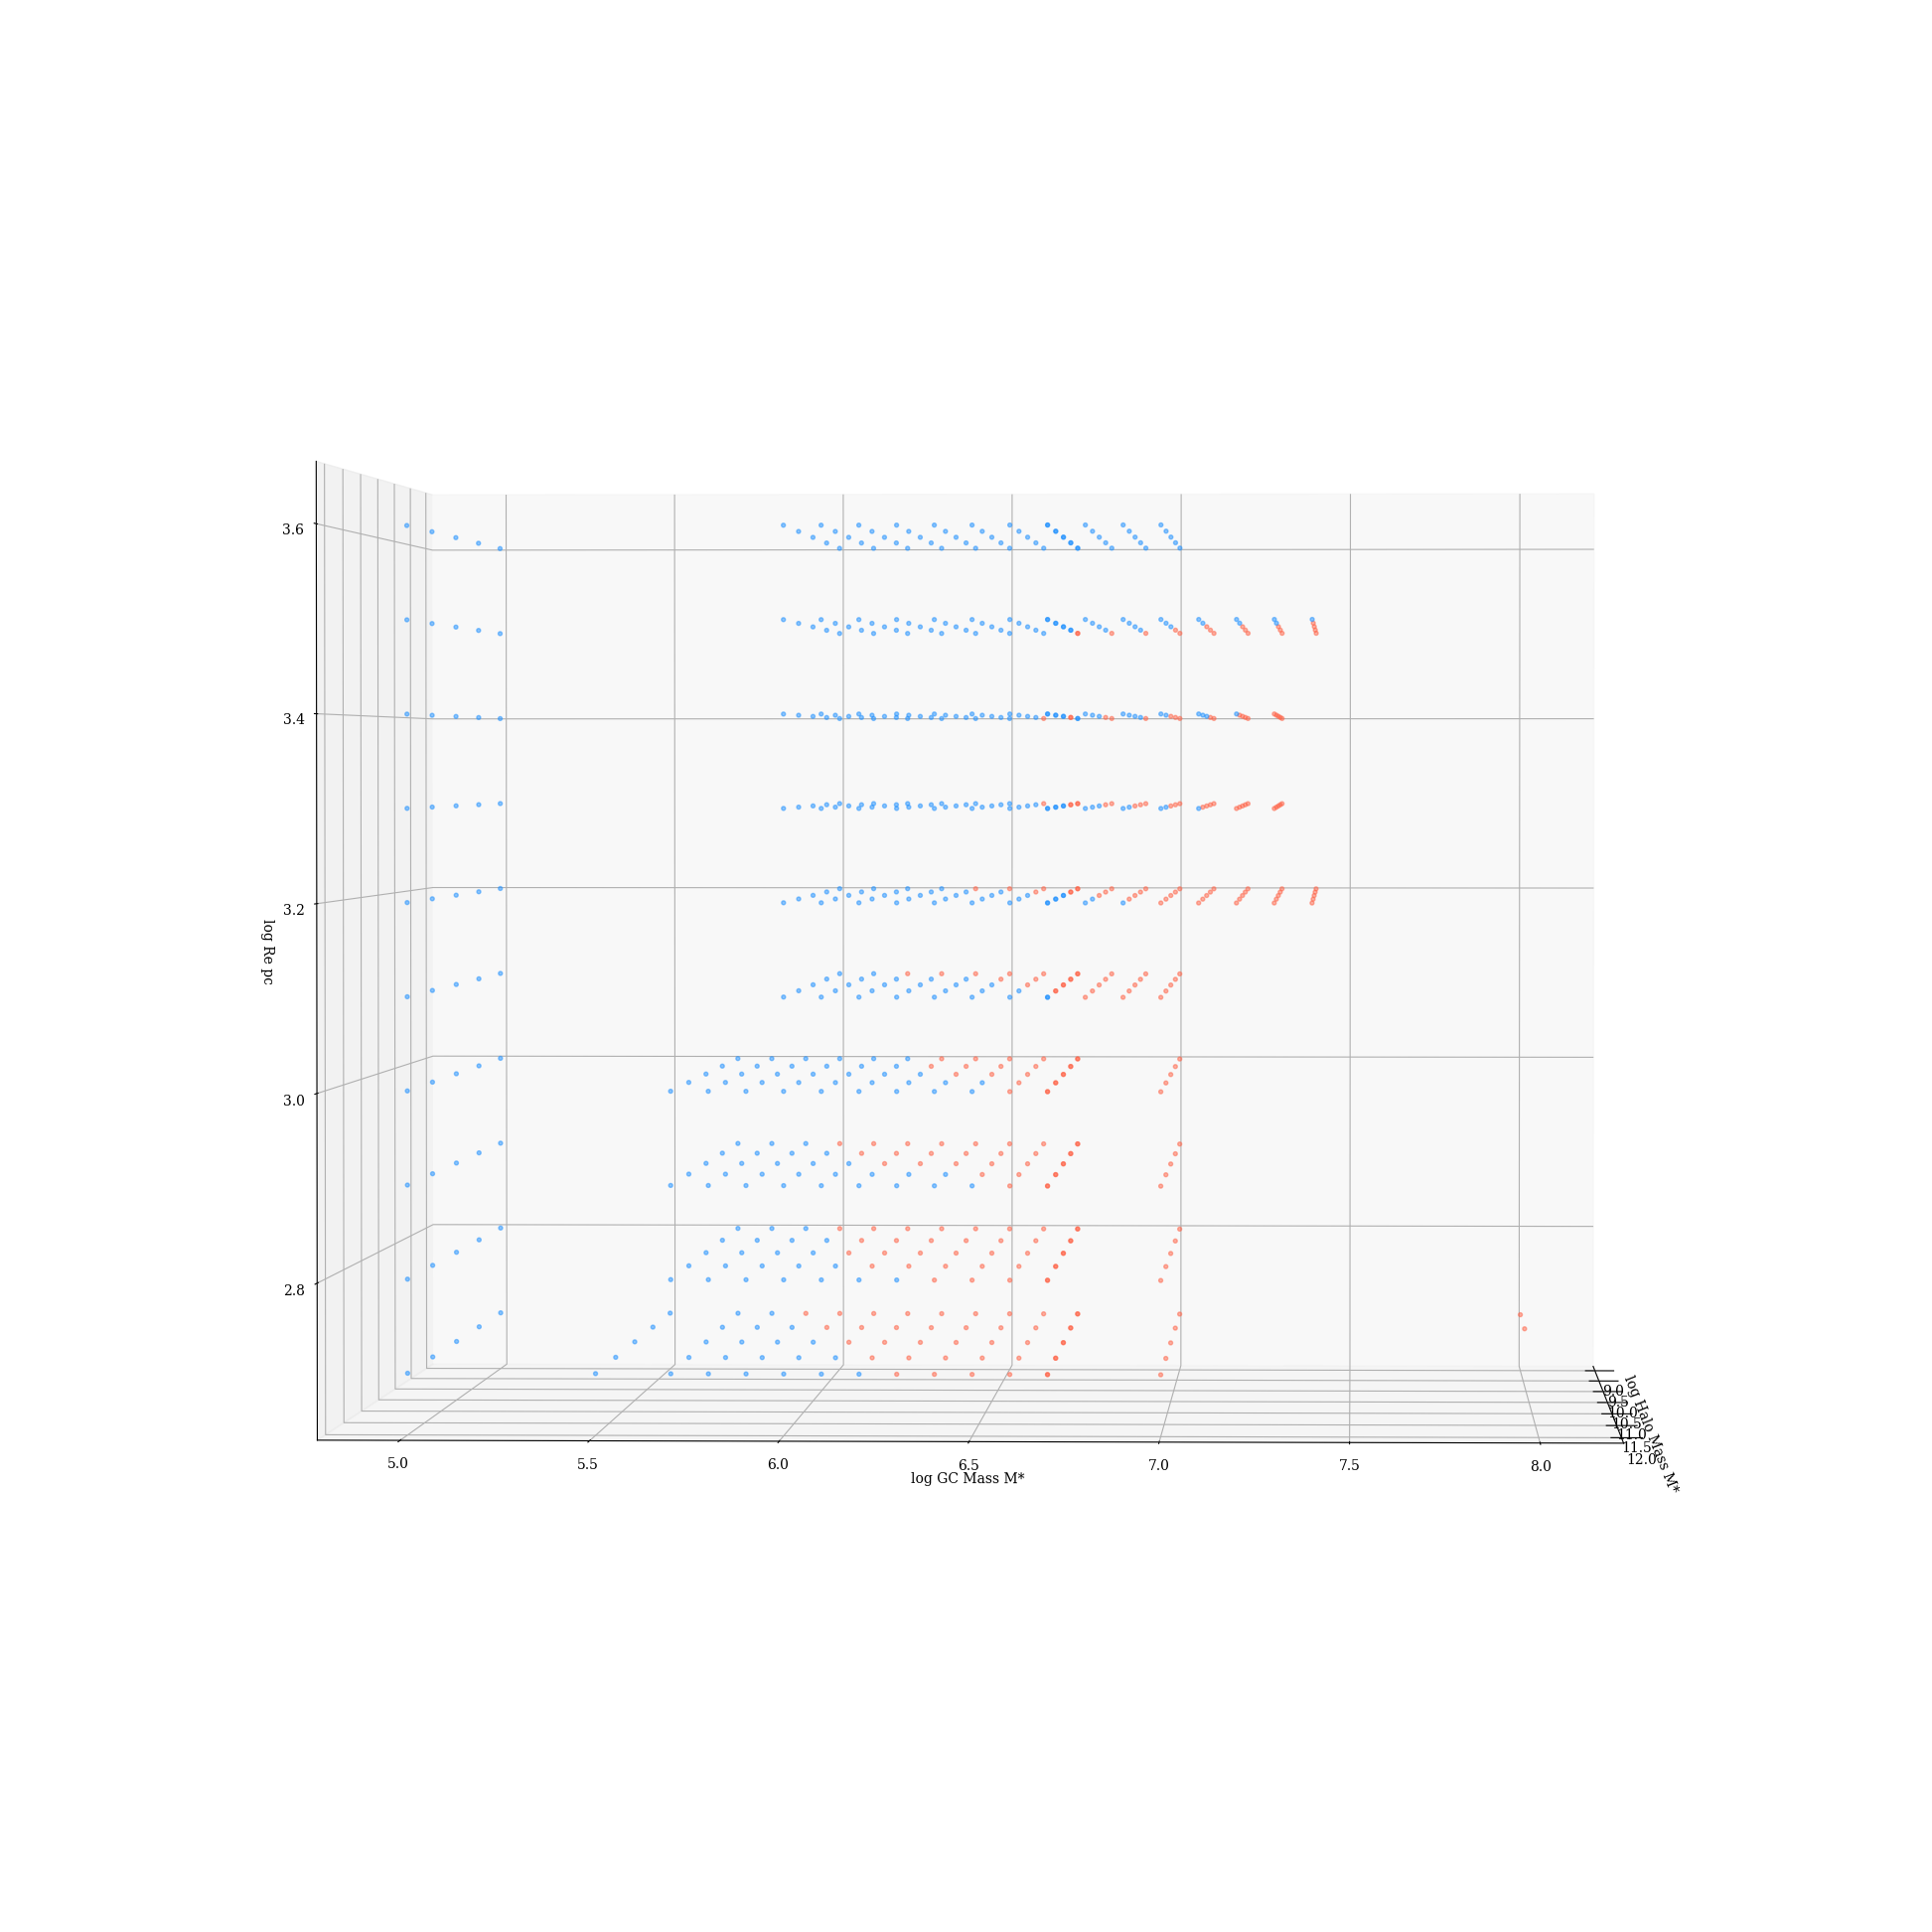

In [4]:
# Load the NumPy file
grid_data = np.load("grid_merger_classification.npy")

# Split into individual components
R_es, GC_masses, halo_masses, mergers = grid_data[:, 0], grid_data[:, 1], grid_data[:, 2], grid_data[:, 3]

def d3_plot(R_es, GC_masses, halo_masses, mergers, elev=5, azim=183, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(25,25))
        ax = fig.add_subplot(111, projection='3d')

    if mergers is None:
        colors = 'dodgerblue'
    else:
        colors = ['tomato' if m == 1 else 'dodgerblue' for m in mergers]
    
    ax.scatter(halo_masses, GC_masses, R_es, c=colors, alpha = 0.5, s = 8)
    # ax.set_xlim(1.5, 1.7)
    ax.set_zlabel('log Re pc')
    ax.set_ylabel('log GC Mass M*')
    ax.set_xlabel('log Halo Mass M*')
    
    ax.view_init(elev=elev, azim=azim)
    
    # plt.savefig('3d_grid_plot1.png')
    
    return ax
    
d3_plot(R_es, GC_masses, halo_masses, mergers, elev=1, azim=2)


In [5]:
# Load the existing grid and classifications from the .npy file
existing_grid = np.load("grid_merger_classification.npy")  
R_es = np.round(np.arange(2.7, 3.7, 0.1), 1)
halo_masses = grid_data[:, 2]  
GC_masses = np.round(np.arange(4, 9.1, 0.1), 1)

# Create a list for the updated grid
new_points = []


for R_e in R_es:
    for halo_mass in halo_masses:
        for GC_mass in GC_masses:
            GC_mass = np.round(GC_mass, 1)
            
            #add points to grid, not in simulated 
            if GC_mass <= 5.6 and R_e < 3.1 and R_e!=5:
                merger_status = 0  # Blue (no merger):
            elif GC_mass < 6 and R_e >= 3.1 and R_e!=5:
                merger_status = 0  # Blue (no merger):
            elif GC_mass > 7 and R_e<3.2:
                merger_status = 1  # Red (merger)
            elif GC_mass >= 7.4 and R_e < 3.5:
                merger_status = 1  # Red (merger)
            elif GC_mass > 7 and R_e == 3.6:
                merger_status = 0  # Blue (no merger)
            elif (GC_mass == 6.8 or GC_mass ==6.9) and R_e <= 3:
                merger_status = 1  # Red (merger)
            elif R_e == 3.5 and GC_mass > 7.4:
                merger_status = 1  # Red (merger)
                
            else:
                continue  # Skip intermediate GC mass values
                
                # Add the new point
            new_points.append([R_e, GC_mass, halo_mass, merger_status])
            

# Convert the new points to a NumPy array
new_points = np.array(new_points)

# Combine the existing and new grids
combined_grid = np.vstack([existing_grid, new_points])

# Save the updated grid as a .npy file
np.save("updated_grid_merger_classification.npy", combined_grid)

print("Updated grid saved to updated_grid_merger_classification.npy")


Updated grid saved to updated_grid_merger_classification.npy


<Axes3DSubplot:xlabel='log Halo Mass M*', ylabel='log GC Mass M*'>

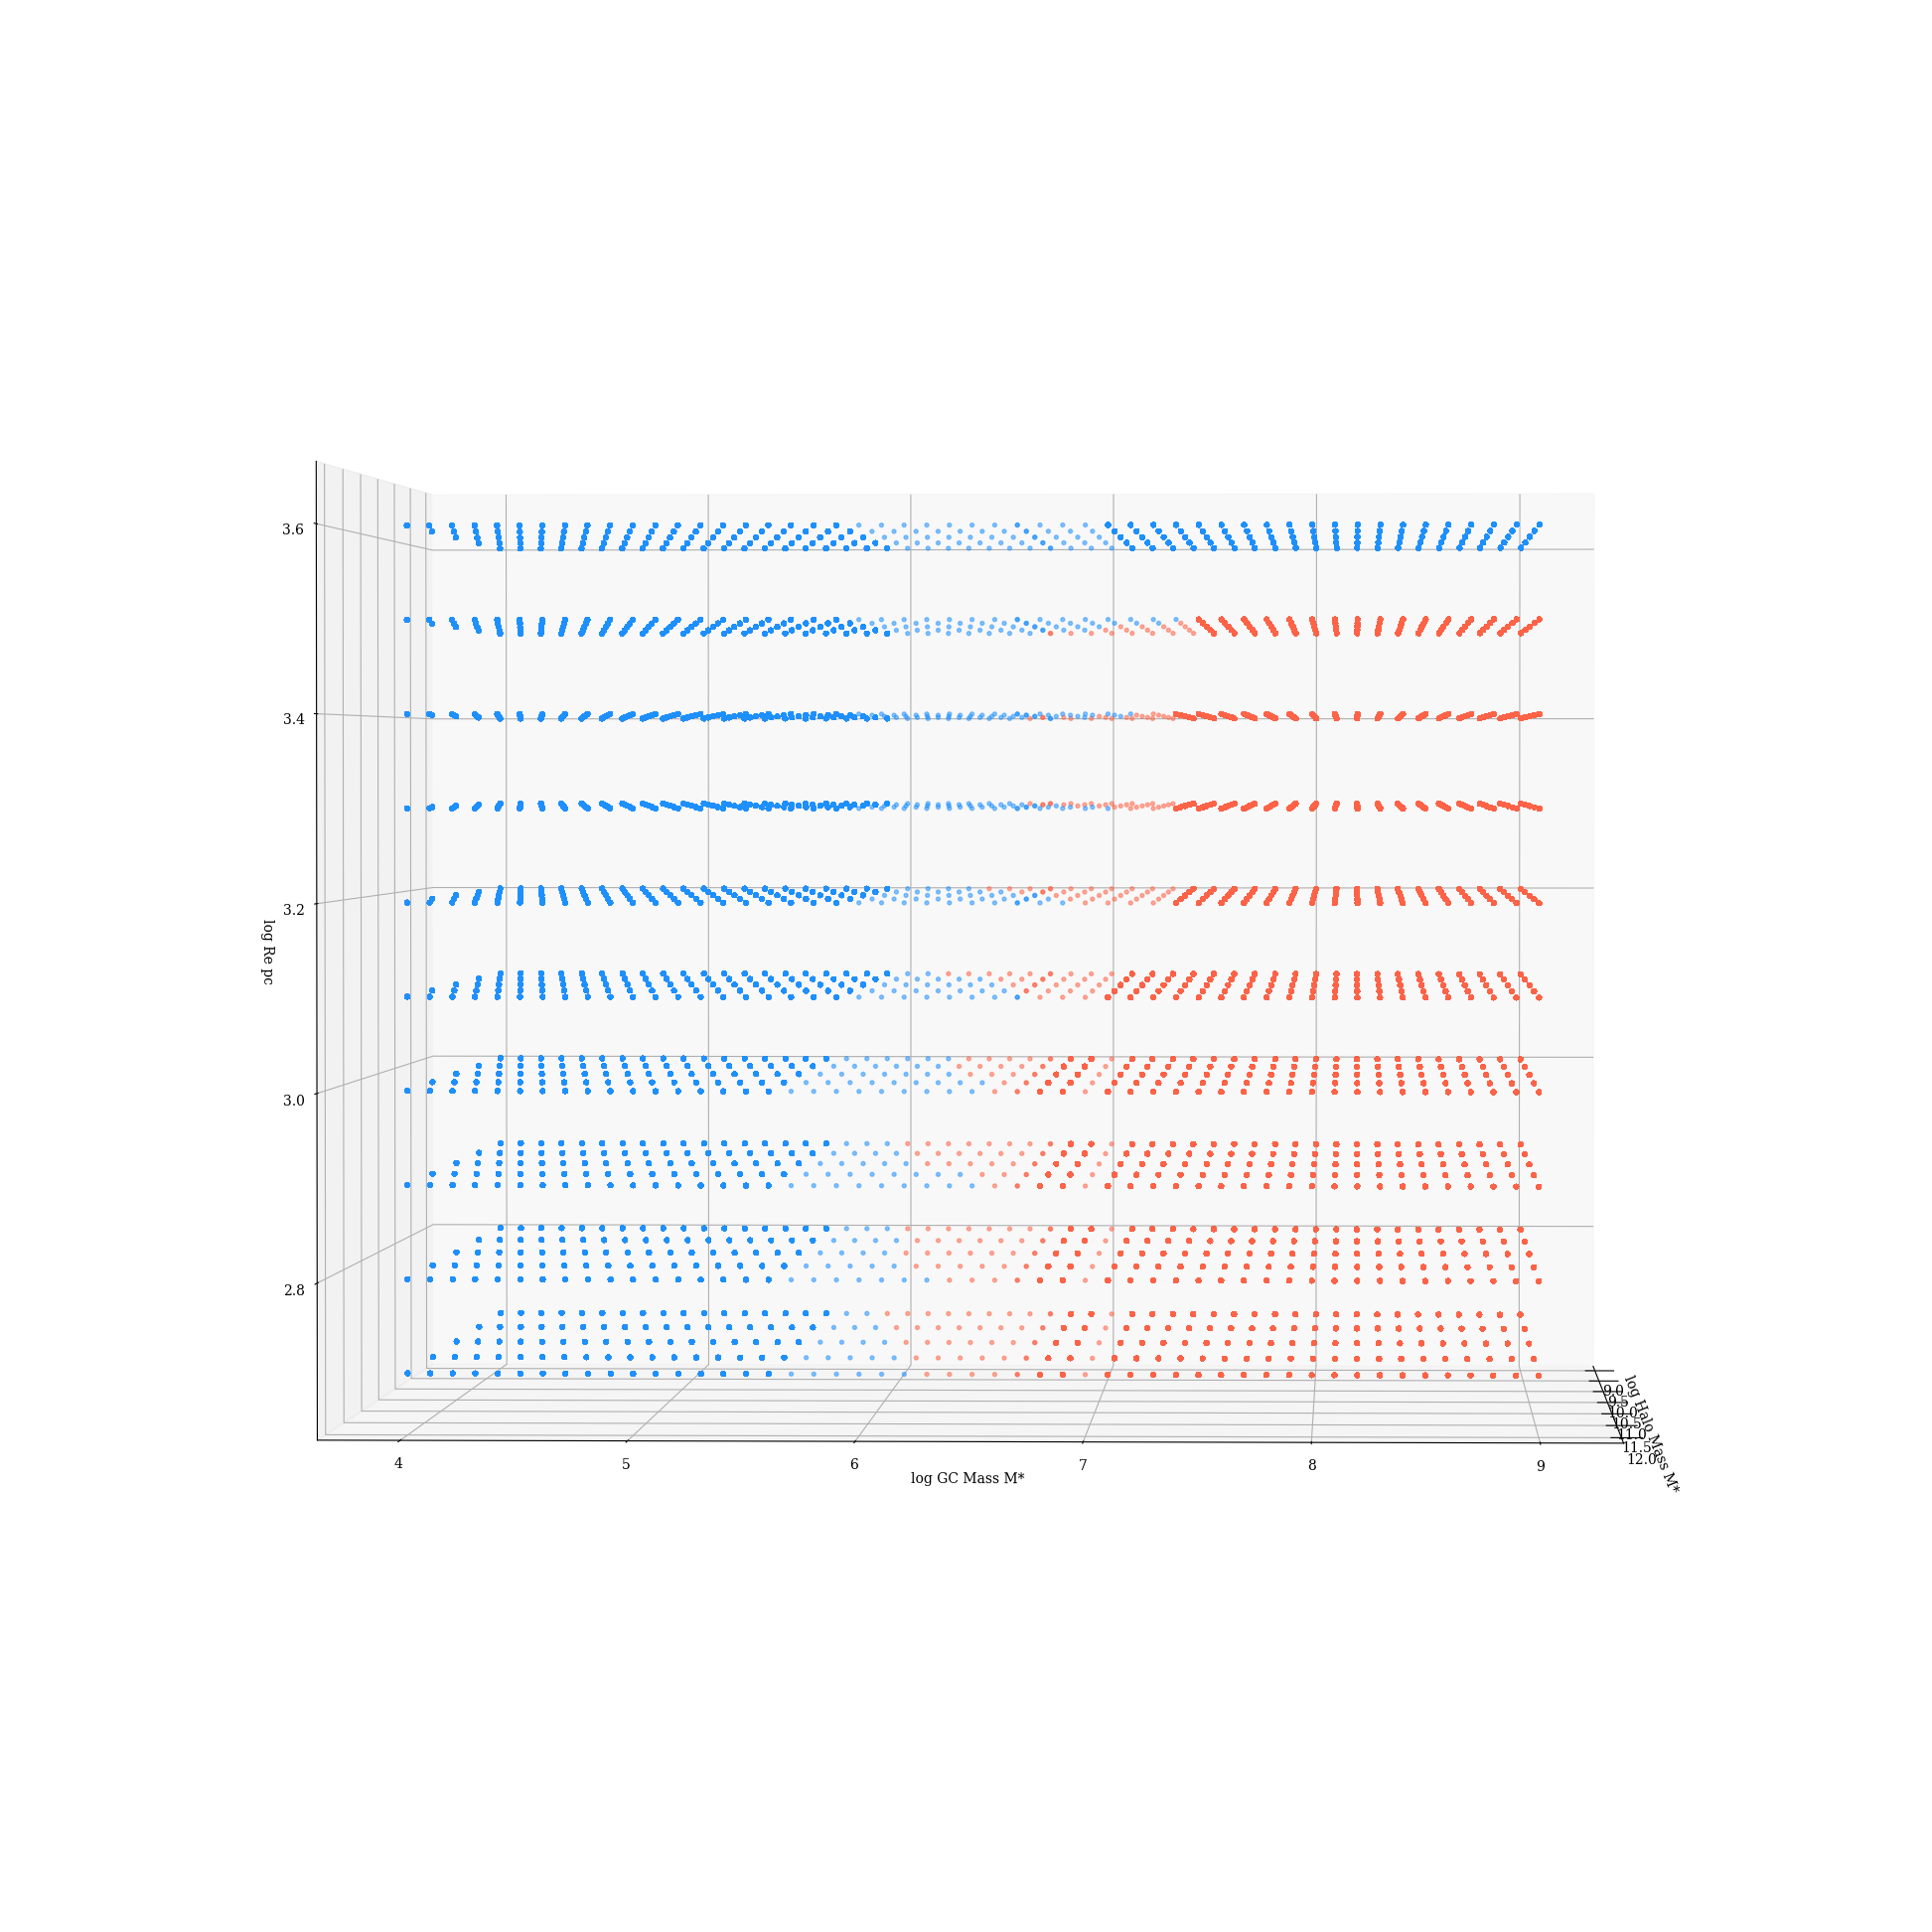

In [6]:
# Load the NumPy file
grid_data = np.load("updated_grid_merger_classification.npy")

# Split into individual components
R_es, GC_masses, halo_masses, mergers = grid_data[:, 0], grid_data[:, 1], grid_data[:, 2], grid_data[:, 3]
d3_plot(R_es, GC_masses, halo_masses, mergers, elev=1, azim=2)





## Samples from distribution

In [35]:
logMStellar = 9
n = 10000
all_DM_samples = np.log10(DM_random_sample(logMStellar, n))
all_Re_samples = np.log10(Re_random_sample(logMStellar, n))
all_GC_samples = np.log10(modified_GC_random_sample(logMStellar, n))
all_logMStellars = np.full(n, logMStellar)


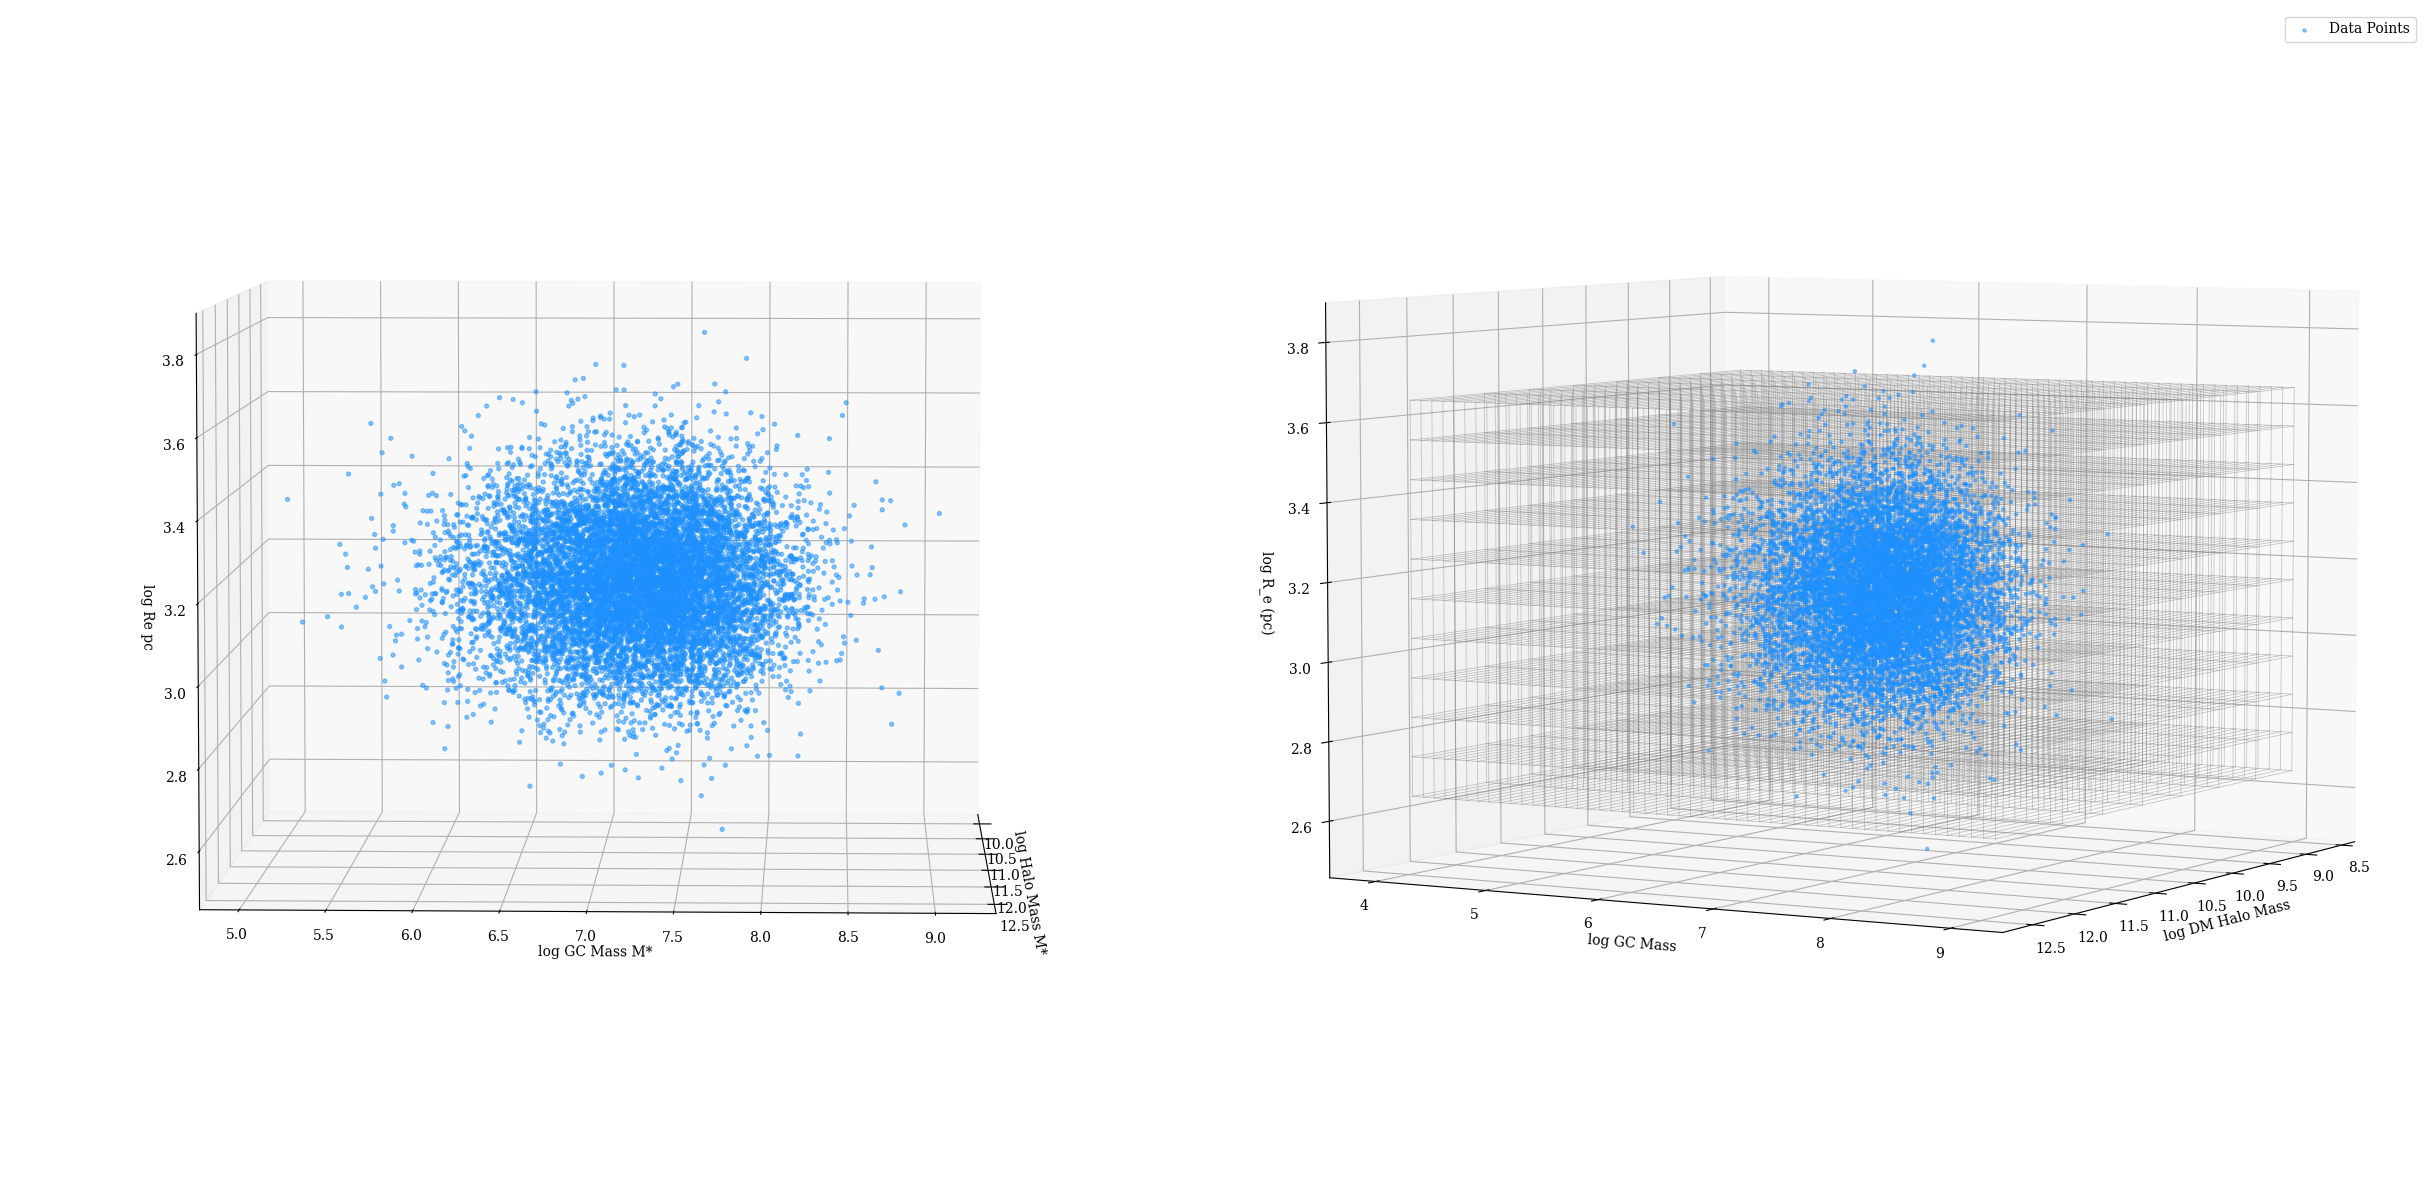

In [36]:
# Define bin centers
GC_centers = np.arange(4, 9.1, 0.1)
Re_centers = np.arange(2.7, 3.7, 0.1)
DM_centers = np.arange(9.0, 12.5, 0.5)

GC_edges = np.append(GC_centers - 0.05, GC_centers[-1] + 0.05)
Re_edges = np.append(Re_centers - 0.05, Re_centers[-1] + 0.05)
DM_edges = np.append(DM_centers - 0.4, DM_centers[-1] + 0.4)


# Plot 2: With bins
def d3_plot_with_bins(GC_samples, Re_samples, DM_samples, elev=5, azim=2, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(25,25))
        ax = fig.add_subplot(111, projection='3d')
    
    # Scatter plot of points
    ax.scatter(DM_samples, GC_samples, Re_samples, c='dodgerblue', alpha=0.5, s=5, label='Data Points')

    # Plot bin edges
     # Draw grid lines
    for gc_edge in GC_edges:
        for re_edge in Re_edges:
            # Vertical lines along DM axis
            ax.plot([DM_edges[0], DM_edges[-1]], [gc_edge, gc_edge], [re_edge, re_edge],
                    color='gray', alpha=0.5, linewidth=0.5)

    for gc_edge in GC_edges:
        for dm_edge in DM_edges:
            # Horizontal lines along Re axis
            ax.plot([dm_edge, dm_edge], [gc_edge, gc_edge], [Re_edges[0], Re_edges[-1]],
                    color='gray', alpha=0.5, linewidth=0.5)

    for re_edge in Re_edges:
        for dm_edge in DM_edges:
            # Vertical lines along GC axis
            ax.plot([dm_edge, dm_edge], [GC_edges[0], GC_edges[-1]], [re_edge, re_edge],
                    color='gray', alpha=0.5, linewidth=0.5)

    # Labels and viewing angle
    ax.set_xlabel('log DM Halo Mass')
    ax.set_ylabel('log GC Mass')
    ax.set_zlabel('log R_e (pc)')
    ax.view_init(elev=elev, azim=azim)
    ax.legend()
    return ax


fig = plt.figure(figsize=(25, 12))

# Left: Scatter plot
ax1 = fig.add_subplot(121, projection='3d')
d3_plot(all_Re_samples, all_GC_samples, all_DM_samples, mergers=None, elev=5, azim=2, ax=ax1)

# Right: Binned plot
ax2 = fig.add_subplot(122, projection='3d')
d3_plot_with_bins(all_GC_samples, all_Re_samples, all_DM_samples, elev=5, azim=30, ax=ax2)

plt.tight_layout()
plt.show()


## Get fraction

In [45]:
# logMStellar = 9
# n = 10000
# all_DM_samples = np.log10(DM_random_sample(logMStellar, n))
# all_Re_samples = np.log10(Re_random_sample(logMStellar, n))
# all_GC_samples = np.log10(modified_GC_random_sample(logMStellar, n))
# all_logMStellars = np.full(n, logMStellar)


# GC_centers = np.arange(4, 9.1, 0.1)
# Re_centers = np.arange(2.7, 3.7, 0.1)
# DM_centers = np.arange(9.0, 12.5, 0.5)

# # center each bin around re and gc vals, one halo val per bin
# GC_edges = np.append(GC_centers - 0.05, GC_centers[-1] + 0.05)
# Re_edges = np.append(Re_centers - 0.05, Re_centers[-1] + 0.05)
# DM_edges = np.append(DM_centers - 0.4, DM_centers[-1] + 0.4)


# grid_data = np.load("updated_grid_merger_classification.npy")

# log_Re = grid_data[:, 0]
# log_GC_mass = grid_data[:, 1]
# log_halo_mass = grid_data[:, 2]
# uniform_grid = grid_data[:, 3]  # 0 (no merger) or 1 (merger)

# merger_points = grid_data[uniform_grid == 1]

# merger_Re = merger_points[:, 0]
# merger_GC_mass = merger_points[:, 1]
# merger_halo_mass = merger_points[:, 2]

# # Count grid points and mergers in each bin
# uniform_grid_counts, edges = np.histogramdd((log_GC_mass, log_Re, log_halo_mass),
#                                       bins=(GC_edges, Re_edges, DM_edges))
# merger_counts, edges = np.histogramdd((merger_GC_mass, merger_Re, merger_halo_mass),
#                                       bins=(GC_edges, Re_edges, DM_edges))

# merger_fractions = np.divide(
#     merger_counts,
#     uniform_grid_counts,
#     out=np.zeros_like(merger_counts, dtype=float),  # Set default to 0
#     where=uniform_grid_counts > 0  # Only divide where counts are non-zero
# )


# # Fraction of points in each bin
# sample_counts, edges = np.histogramdd((all_GC_samples, all_Re_samples, all_DM_samples), 
#                                          bins=(GC_edges, Re_edges, DM_edges))

# sample_fractions = sample_counts / n  # get fractions

# # Calculate the weighted fraction of mergers for this stellar mass
# weighted_mergers = sample_fractions * merger_fractions
# total_merger_fraction = np.sum(weighted_mergers)

# print(f"Total merger fraction for log Mstellar = {logMStellar}: {total_merger_fraction:.4f}")


# Get Fraction Modified (Shaunak)

In [3]:
def get_NSC_frac(all_Re_samples, all_GC_samples, all_DM_samples):
    
    grid_data = np.load("updated_grid_merger_classification.npy")
    log_Re = grid_data[:, 0]
    log_GC_mass = grid_data[:, 1]
    log_halo_mass = grid_data[:, 2]
    uniform_grid = grid_data[:, 3]  # 0 (no merger) or 1 (merger)
    
    merger_count = 0
    for i in range(n):
    	# get the coordinates (DM_i, Re_i, GC_i) of point i
        DM_i = all_DM_samples[i]
        Re_i = all_Re_samples[i]
        GC_i = all_GC_samples[i]
        
    	# get the nearest gridpoint values of (DM, Re, GC) (ex. nearest_grid_DM = np.argmin(DM_values, DM_i))
        closest_halo = log_halo_mass[np.argmin((log_halo_mass - DM_i)**2)]
        closest_Re = log_Re[np.argmin((log_Re - Re_i)**2)]
        closest_GC = log_GC_mass[np.argmin((log_GC_mass - GC_i)**2)]
        
        indx = np.where((log_halo_mass == closest_halo) & 
                        (log_Re == closest_Re) & 
                        (log_GC_mass == closest_GC))[0][0]
    
        # index of nearest grid point
    	# merger_count += value of the merger array at those gridpoint values
        merger_i = uniform_grid[indx]
        merger_count += merger_i
    
    
    merger_fraction = merger_count/n
    print(f"Total merger fraction for log Mstellar = {logMStellar}: {merger_fraction:.4f}")

    return merger_fraction


In [5]:
logMStellars = [7.5, 8, 8.5, 9]
n = 10000

plot_fracs = []
plot_errors = []

for logMStellar in logMStellars:

    all_DM_samples = np.log10(DM_random_sample(logMStellar, n))
    all_Re_samples = np.log10(Re_random_sample(logMStellar, n))
    all_GC_samples = np.log10(modified_GC_random_sample(logMStellar, n))
    all_logMStellars = np.full(n, logMStellar)

    std_Re = 0.152 #log space
    
    sigma0 = 0.02
    nu = -0.47
    M1 = 11.889
    std_DM = sigma0 + nu * (all_DM_samples - M1) #log sigma
        
    std_GC = 0.5 #log space
    
    
    shifts = [-1, 1]  #+1 and -1 std
    central_frac = get_NSC_frac(all_Re_samples, all_GC_samples, all_DM_samples)
    fractions = [central_frac]
    
    for halo in shifts:
        for re in shifts:
            for gc in shifts:
                DM_shifted = all_DM_samples + halo * std_DM
                Re_shifted = all_Re_samples + re * std_Re
                GC_shifted = all_GC_samples + gc * std_GC
                
                fraction = get_NSC_frac(Re_shifted, GC_shifted, DM_shifted)
                fractions.append(fraction)


    fractions = np.array(fractions)
    error = np.std(fractions)

    plot_fracs.append(np.mean(fractions))
    plot_errors.append(error)
    
    print(f"Central nucleation fraction: {central_frac}")
    print(f"Error bar: {error}")


Total merger fraction for log Mstellar = 7.5: 0.1175
Total merger fraction for log Mstellar = 7.5: 0.0381
Total merger fraction for log Mstellar = 7.5: 0.6120
Total merger fraction for log Mstellar = 7.5: 0.0096
Total merger fraction for log Mstellar = 7.5: 0.3408
Total merger fraction for log Mstellar = 7.5: 0.0150
Total merger fraction for log Mstellar = 7.5: 0.4666
Total merger fraction for log Mstellar = 7.5: 0.0018
Total merger fraction for log Mstellar = 7.5: 0.1831
Central nucleation fraction: 0.1175
Error bar: 0.21178641640303447
Total merger fraction for log Mstellar = 8: 0.2506
Total merger fraction for log Mstellar = 8: 0.1463
Total merger fraction for log Mstellar = 8: 0.7885
Total merger fraction for log Mstellar = 8: 0.0340
Total merger fraction for log Mstellar = 8: 0.5137
Total merger fraction for log Mstellar = 8: 0.0678
Total merger fraction for log Mstellar = 8: 0.6788
Total merger fraction for log Mstellar = 8: 0.0083
Total merger fraction for log Mstellar = 8: 0.34

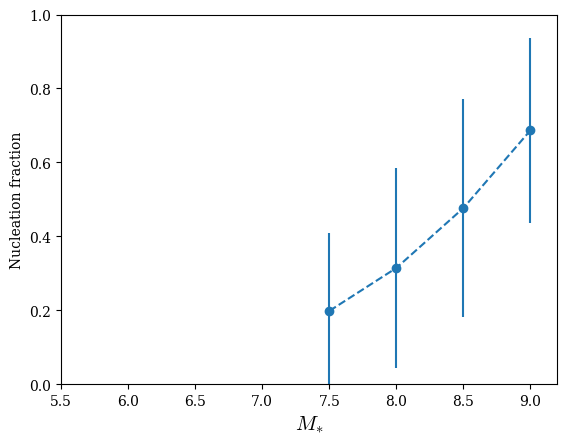

In [7]:
plt.figure()
plt.errorbar(logMStellars, plot_fracs, yerr = plot_errors, fmt = 'o', ls='--')
plt.xlabel(r'$M_{*}$', fontsize = 15)
plt.ylabel('Nucleation fraction')
plt.xlim(5.5, 9.2)
plt.ylim(0, 1)
# plt.savefig('nucleation_fraction.png')
plt.show()

In [3]:
logMStellars = [7.5, 8, 8.5, 9]
frac_avg = []
frac_std = []
for logMStellar in logMStellars:
    iters = 10
    fracs = []
    for i in range(iters):
        fracs.append(get_NSC_frac(logMStellar))
    frac_avg.append(np.mean(fracs))
    frac_std.append(np.std(fracs))

Total merger fraction for log Mstellar = 7.5: 0.1199
Total merger fraction for log Mstellar = 7.5: 0.1119
Total merger fraction for log Mstellar = 7.5: 0.1204
Total merger fraction for log Mstellar = 7.5: 0.1194
Total merger fraction for log Mstellar = 7.5: 0.1220
Total merger fraction for log Mstellar = 7.5: 0.1288
Total merger fraction for log Mstellar = 7.5: 0.1201
Total merger fraction for log Mstellar = 7.5: 0.1216
Total merger fraction for log Mstellar = 7.5: 0.1243
Total merger fraction for log Mstellar = 7.5: 0.1172
Total merger fraction for log Mstellar = 8: 0.2497
Total merger fraction for log Mstellar = 8: 0.2522
Total merger fraction for log Mstellar = 8: 0.2547
Total merger fraction for log Mstellar = 8: 0.2474
Total merger fraction for log Mstellar = 8: 0.2514
Total merger fraction for log Mstellar = 8: 0.2565
Total merger fraction for log Mstellar = 8: 0.2556
Total merger fraction for log Mstellar = 8: 0.2577
Total merger fraction for log Mstellar = 8: 0.2561
Total merge

In [1]:
plt.figure()
plt.errorbar(logMStellars, frac_avg, yerr = frac_std, fmt = 'o', ls='--')
plt.xlabel(r'$M_{*}$', fontsize = 15)
plt.ylabel('Nucleation fraction')
plt.xlim(5.5, 9.2)
plt.ylim(0, 1)
# plt.savefig('nucleation_fraction.png')
plt.show()

NameError: name 'plt' is not defined

# DEBUGGING

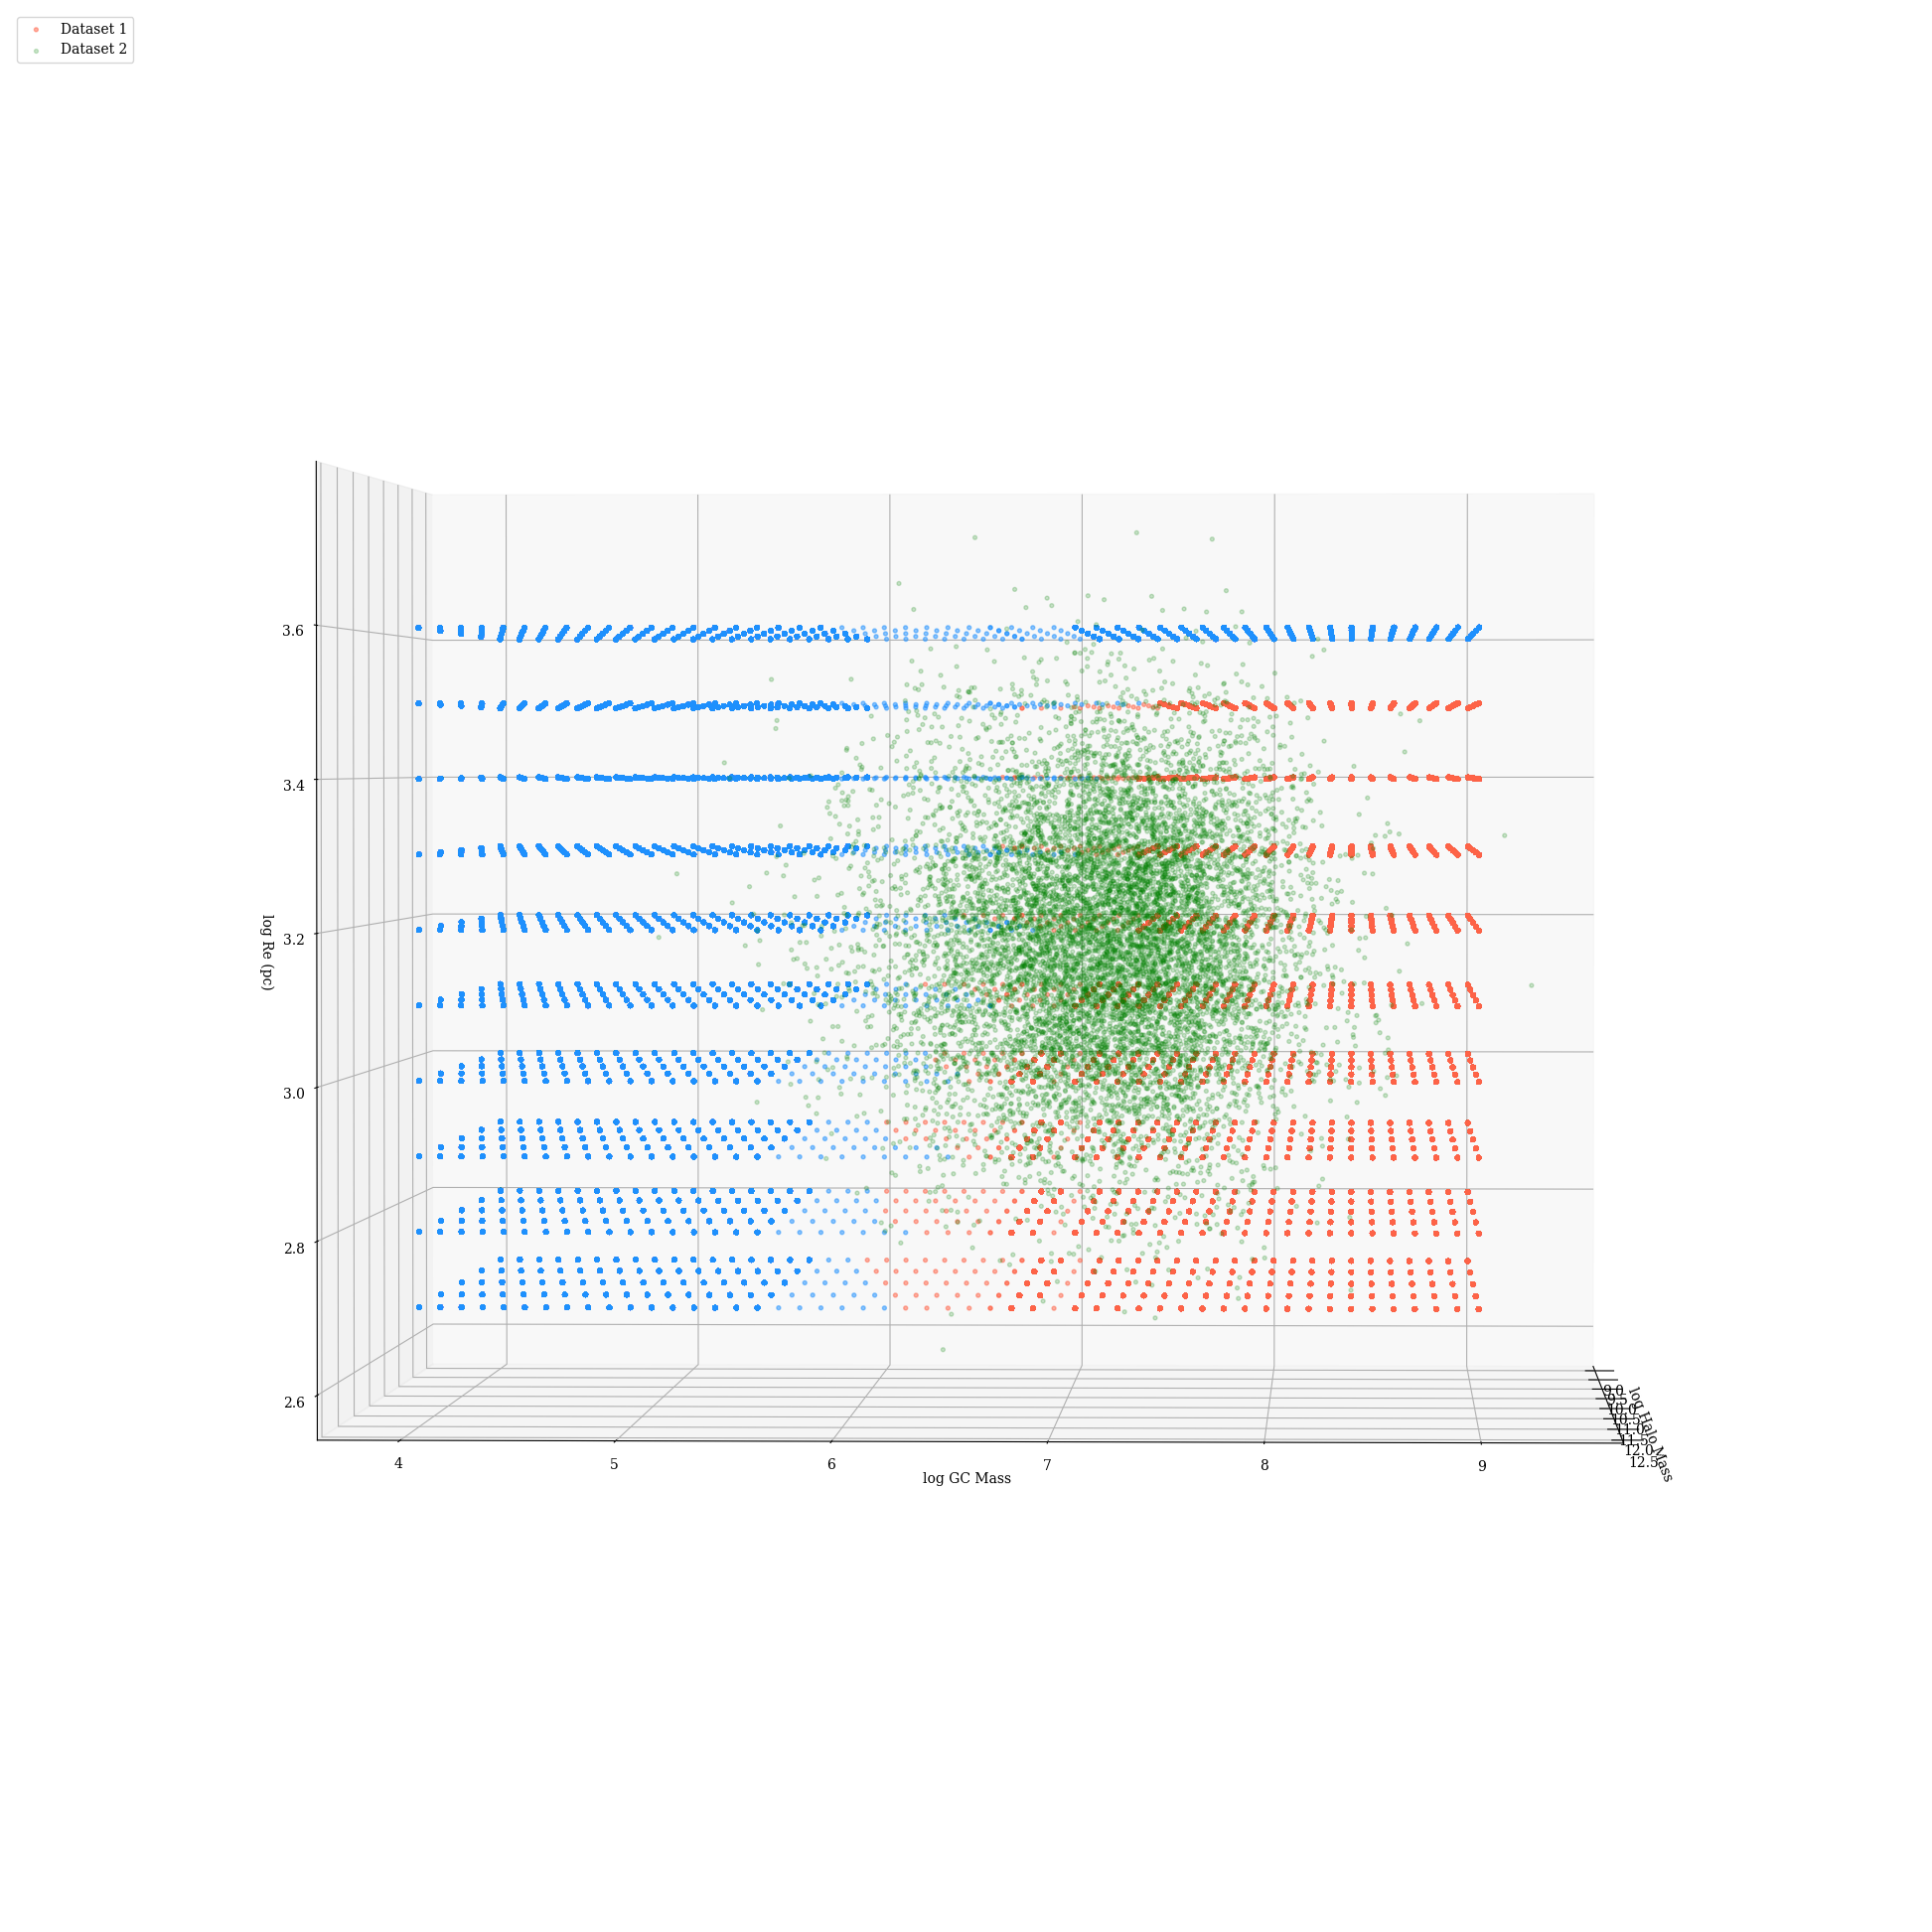

In [16]:
logMStellar = 8.5
n = 10000
all_DM_samples = np.log10(DM_random_sample(logMStellar, n))
all_Re_samples = np.log10(Re_random_sample(logMStellar, n))
all_GC_samples = np.log10(modified_GC_random_sample(logMStellar, n))
all_logMStellars = np.full(n, logMStellar)
# Load the NumPy file
grid_data = np.load("updated_grid_merger_classification.npy")

# Split into individual components
R_es, GC_masses, halo_masses, mergers = grid_data[:, 0], grid_data[:, 1], grid_data[:, 2], grid_data[:, 3]


def combined_d3_plot(
    R_es1, GC_masses1, halo_masses1, mergers1,
    R_es2, GC_masses2, halo_masses2, mergers2=None,
    elev=1, azim=2
):
    fig = plt.figure(figsize=(25, 25))
    ax = fig.add_subplot(111, projection='3d')

    # Plot first dataset
    if mergers1 is not None:
        colors1 = ['tomato' if m == 1 else 'dodgerblue' for m in mergers1]
    else:
        colors1 = 'blue'
    ax.scatter(halo_masses1, GC_masses1, R_es1, c=colors1, alpha=0.5, s=8, label='Dataset 1')

    # Plot second dataset
    if mergers2 is not None:
        colors2 = ['tomato' if m == 1 else 'dodgerblue' for m in mergers2]
    else:
        colors2 = 'green'
    ax.scatter(halo_masses2, GC_masses2, R_es2, c=colors2, alpha=0.2, s=8, label='Dataset 2')

    # Labels and viewing angle
    ax.set_xlabel('log Halo Mass')
    ax.set_ylabel('log GC Mass')
    ax.set_zlabel('log Re (pc)')
    ax.view_init(elev=elev, azim=azim)

    # Legend
    ax.legend(loc='upper left')
    plt.show()

# Call the combined plot function
combined_d3_plot(
    R_es, GC_masses, halo_masses, mergers,
    all_Re_samples, all_GC_samples, all_DM_samples, None,
    elev=1, azim=2
)


In [17]:
print("Shape of uniform_grid_counts:", uniform_grid_counts.shape)
print("Shape of merger_counts:", merger_counts.shape)
print("Shape of sample_fractions:", sample_fractions.shape)

print("Total counts in uniform grid:", np.sum(uniform_grid_counts))
print("Total counts in merger grid:", np.sum(merger_counts))
print("Total sampled points:", np.sum(sample_counts))

print("Max and Min of merger_fractions:", np.max(merger_fractions), np.min(merger_fractions))
print("Weighted mergers shape:", weighted_mergers.shape)


Shape of uniform_grid_counts: (51, 10, 7)
Shape of merger_counts: (51, 10, 7)
Shape of sample_fractions: (51, 10, 7)
Total counts in uniform grid: 286848.0
Total counts in merger grid: 131015.0
Total sampled points: 9990.0
Max and Min of merger_fractions: 1.0 0.0
Weighted mergers shape: (51, 10, 7)
